### Configs

In [1]:
colab = 0

lr_OD = 0.005
lr_DD = 0.005

convert2png = 0

num_classes = 894

num_epochs = 50

load_model = 0
save_model = 0

if colab==0:
    root_folder = "Datas"
    OD_model_save_dir = "Models/ODModel.pth.tar"
    OD_logs_path = "Logs/ODLogs.txt"
else:
    root_folder = "/content/drive/My Drive/Courses/DeepLearning/Project/Datas"
    
    OD_model_save_dir = "/content/drive/My Drive/Courses/DeepLearning/Project/Models/ODModel.pth.tar"
    OD_logs_path = "/content/drive/My Drive/Courses/DeepLearning/Project/Logs/ODLogs.txt"
    
    DD_model_save_dir = "/content/drive/My Drive/Courses/DeepLearning/Project/Models/DDModel.pth.tar"
    DD_logs_path = "/content/drive/My Drive/Courses/DeepLearning/Project/Logs/DDLogs.txt"

### Imports

In [2]:
if colab:
    !pip install mat73
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    sys.path.append("/content/drive/My Drive/Courses/DeepLearning/Project")

## Python Files

import utils
import datas
import models

## Libraries
import os  # when loading file paths

from PIL import Image  # Load img
import torch
import torch.nn as nn
import statistics
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import mat73

### Setting up GPU Device

In [3]:
# Setting device on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

torch.backends.cudnn.deterministic = True

Using device: cpu



### Convert .mat to .png images for memory managment during training

In [4]:
if convert2png:
    path2dataset = "nyu_depth_v2_labeled.mat"
    utils.mat2png(path2dataset)

### Load datas

In [5]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import datas

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


transform = get_transform(train=True)

train_loader, test_loader = datas.get_loader(root_folder, batch_size=4, num_datas=1449, train_test_ratio=0.9, transform=transform)

In [6]:
images, depths, targets = next(iter(train_loader))

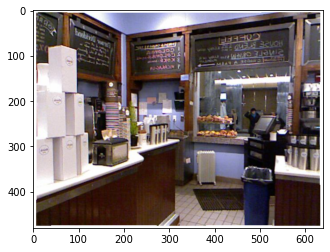

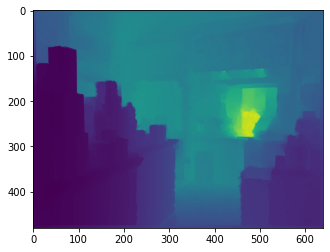

In [7]:
plt.imshow(images[2].permute(1,2,0).cpu().numpy())
plt.figure()
plt.imshow(depths[2].permute(1,2,0).cpu().numpy())

### Training  - Object Detector

In [8]:
object_detector = models.ObjectDetector(num_classes=num_classes).to(device)
criterion = nn.MSELoss().to(device)
params = [p for p in object_detector.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr_OD,
                            momentum=0.9, weight_decay=0.0005)

In [ ]:
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    object_detector.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

def save_checkpoint(state, filename=OD_model_save_dir):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def write_log(file_path, stat):
  with open(file_path, 'a') as f:
    f.write("{0}\n".format(stat))

if load_model:
      load_checkpoint(torch.load(OD_model_save_dir), object_detector, optimizer)

for epoch in range(num_epochs):
    logs = train_one_epoch(object_detector, optimizer, train_loader, device, epoch, print_freq=5, logs_path=OD_logs_path)
    evaluate(object_detector, test_loader, device=device)
    if save_model:
          checkpoint = {
              "state_dict": object_detector.state_dict(),
              "optimizer": optimizer.state_dict(),
              }
          save_checkpoint(checkpoint, filename=OD_model_save_dir)

/Users/mohammadaminalamalhod/anaconda3/envs/DL/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/mohammadaminalamalhod/anaconda3/envs/DL/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/326]  eta: 10:04:42  lr: 0.000020  loss: 9.2622 (9.2622)  loss_classifier: 6.9601 (6.9601)  loss_box_reg: 0.9109 (0.9109)  loss_mask: 0.7139 (0.7139)  loss_objectness: 0.4923 (0.4923)  loss_rpn_box_reg: 0.1850 (0.1850)  time: 111.2948  data: 0.3469


In [17]:
# pick one image from the test set
images, depths, targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
img = images[3]
# put the model in evaluation mode
object_detector.eval()
with torch.no_grad():
    prediction = object_detector([img.to(device)])
    
plt.imshow(img.permute(1,2,0).cpu().numpy())

[{'boxes': tensor([], size=(0, 4)),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([]),
  'masks': tensor([], size=(0, 1, 480, 640))}]

In [ ]:
plot_img = 0
for obj in range(15):
  plot_img = plot_img + prediction[0]['masks'][obj, 0].mul(255)
plt.imshow(plot_img.cpu().numpy())

### Training - Depth Detection